In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import os

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
path_db =  {}

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        path_db[filename.replace('.csv','')] = path
        
path = path_db['WA_Fn-UseC_-Telco-Customer-Churn']
df = pd.read_csv(path)

print(f'Data path: {path} - {df.shape}')

df.head()

Data path: /kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv - (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df['SeniorCitizen']

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: SeniorCitizen, Length: 7043, dtype: int64

In [4]:
# Utiliy Functions for Visualization
def boxplot_wannotation_plot(df: pd.DataFrame) -> None:
    num_columns = len(df.columns)
    num_rows = (num_columns // 3) + (num_columns % 3)

    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 8 * num_rows // 2))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        boxplot = df[col].plot(kind='box', ax=ax, sharex=False, sharey=False,
                            meanline=True, showmeans =True, meanprops={'color': 'red', 'linestyle': '--'})
        ax.set_title(f'{col}')
        ax.set_xticks([])

        # Calculate the median and mean
        median, mean = df[col].median(), df[col].mean()

        # Mean and Median Annotation
        ax.text(0.62, 0.9, f'Median: {median:.2f}', transform=ax.transAxes,
                fontsize=9, verticalalignment='top',color='green')
        ax.text(0.62, 0.8, f'Mean: {mean:.2f}', transform=ax.transAxes,
                fontsize=9, verticalalignment='top',color='red')

        # Outlier calculation and Annotation
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        ax.text(0.62, 0.7, f'Outliers: {len(outliers)}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

    for i in range(num_columns, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    

def distribution_wannotation_plot(df: pd.DataFrame) -> None:
    num_features = len(df.columns) - 1
    num_rows,num_cols = 1, 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8 * num_rows // 2))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        ax = axes[i]
        # Plot All the data points
        sns.histplot(data=df, x=column, bins=20, common_norm=False, ax=ax,
                    legend=False, color='orange', alpha=0.2, edgecolor='none')

        # Plot the data points seperated by hue (Outcome)
        sns.histplot(data=df, x=column, bins=20, common_norm=False, kde=True,
                    ax=ax, legend=False, palette={0: 'blue', 1: 'red'}, alpha=0.4, edgecolor='none')

        mean = df[column].mean()
        var = df[column].var()
        skew = df[column].skew()

        ax.set_title(f'{column}\n(Mean={mean:.2f}, Var={var:.2f}, Skew={skew:.2f})')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

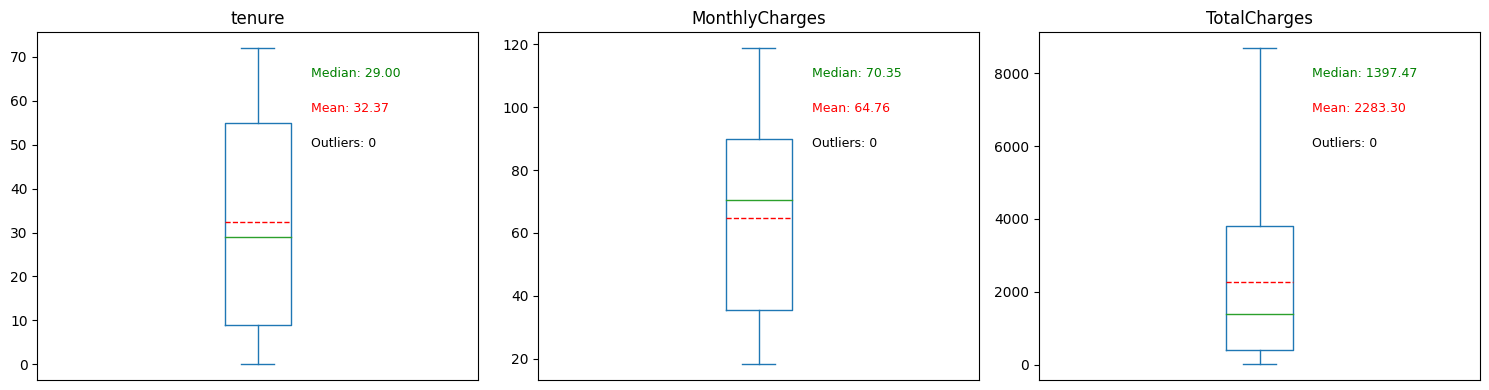

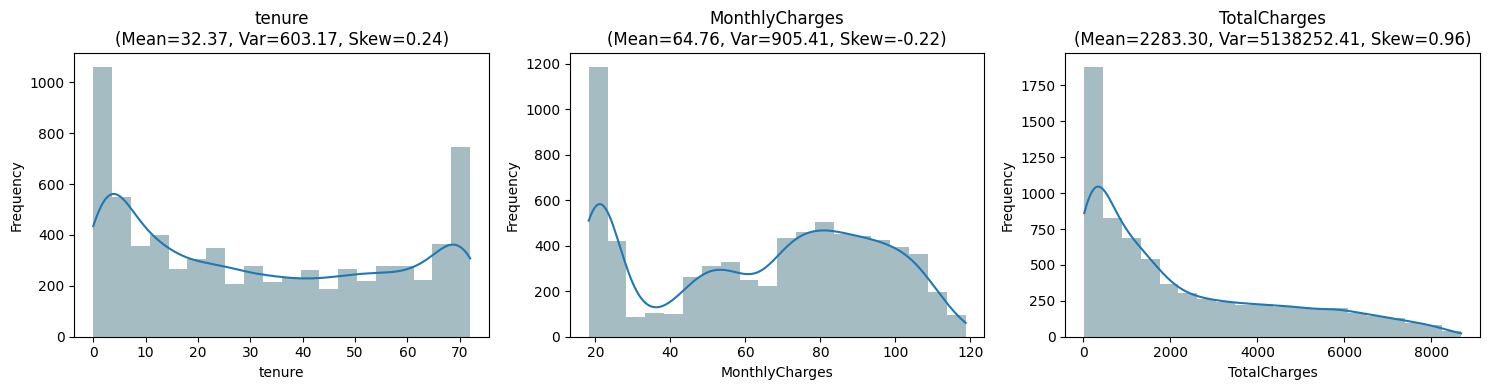

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
numerical_data_col = ['tenure','MonthlyCharges','TotalCharges']
boxplot_wannotation_plot(df[numerical_data_col])
distribution_wannotation_plot(df[numerical_data_col])

There is no outliers among the numerical data in the dataset; hence, we don't have to remove any outliers.

### Preprocess Numerical Data

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Imputation (incase for missing values) based on the visualization
df['tenure'] = df['tenure'].fillna(df['tenure'].mean()) 
df['MonthlyCharges'] = df['MonthlyCharges'].fillna(df['MonthlyCharges'].mean()) 
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median()) 

# Need to perform Z-score Normalization on the numerical data
# Using Z-score Normalization because we DON'T know the possible Range 
znorm_scaler = StandardScaler()

# Using MinMaxScaler to make the data numerical dat within the same range as categorical of [0,1]??
minmax_scaler = MinMaxScaler(feature_range = (0,1))

numerical_data_col = ['tenure','MonthlyCharges','TotalCharges']
numerical_df = df[numerical_data_col]

transnumerical_data_col = [f'{col}_norm' for col in numerical_data_col]
numerical_df[transnumerical_data_col] = znorm_scaler.fit_transform(numerical_df[numerical_data_col])
# numerical_df[transnumerical_data_col] = minmax_scaler.fit_transform(numerical_df[numerical_data_col])

numerical_df.head()

,tenure,MonthlyCharges,TotalCharges,tenure_norm,MonthlyCharges_norm,TotalCharges_norm
0,1,29.85,29.85,-1.277445,-1.160323,-0.994242
1,34,56.95,1889.50,0.066327,-0.259629,-0.173244
2,2,53.85,108.15,-1.236724,-0.362660,-0.959674
3,45,42.30,1840.75,0.514251,-0.746535,-0.194766
4,2,70.70,151.65,-1.236724,0.197365,-0.940470


### Preprocess Categorical Data

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encoding the Categorical Data - including the Churn (Prediction Class)
categorical_df = df.drop(columns = numerical_data_col, axis = 1).iloc[:,1:]
original_categorical_columns = categorical_df.columns.tolist()

label_encoders = {}
label_to_original = {}

# Apply LabelEncoder to each feature and store the direct conversion in a dictionary
for column in categorical_df.select_dtypes(include=['object','int']).columns:
    le = LabelEncoder()
    categorical_df[column + '_Encoded'] = le.fit_transform(categorical_df[column])
    label_encoders[column] = le
    label_to_original[column] = dict(zip(le.transform(categorical_df[column]), categorical_df[column]))

encoded_columns = [col for col in categorical_df.columns if col.endswith('Encoded')]

categorical_df[encoded_columns].head()

,gender_Encoded,SeniorCitizen_Encoded,Partner_Encoded,Dependents_Encoded,PhoneService_Encoded,MultipleLines_Encoded,InternetService_Encoded,OnlineSecurity_Encoded,OnlineBackup_Encoded,DeviceProtection_Encoded,TechSupport_Encoded,StreamingTV_Encoded,StreamingMovies_Encoded,Contract_Encoded,PaperlessBilling_Encoded,PaymentMethod_Encoded,Churn_Encoded
0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


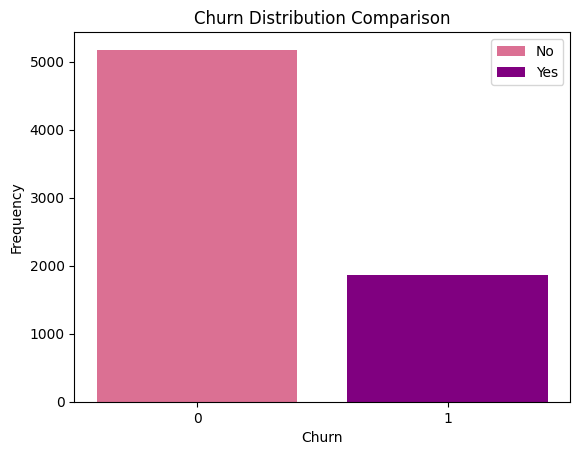

In [8]:
class_labels = label_to_original['Churn']
categorical_df['Churn_Label'] = categorical_df['Churn_Encoded'].map(class_labels)
value_counts = categorical_df['Churn_Encoded'].value_counts()

unique_values = value_counts.index
plt.bar(unique_values, value_counts, color=['palevioletred','purple'], tick_label=unique_values, label=class_labels.values())

plt.xlabel('Churn')
plt.ylabel('Frequency')
plt.title('Churn Distribution Comparison')
plt.legend()
plt.show()

We can clearly see the class imbalance between Churn and Not Churn. Therefore, we have to manipulation methods to increase the number of data

Original Data:
Churn: (1869, 20)
Not Churn: (5174, 20)

Upsample Data:
Churn: (5174, 20)
Not Churn: (5174, 20)

Final Data: (10348, 20)


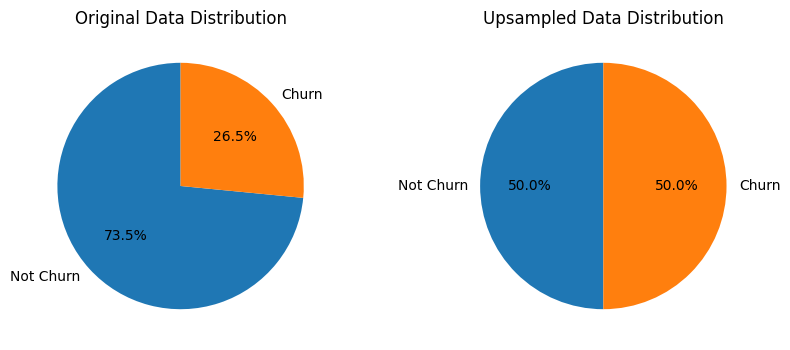

In [9]:
from sklearn.utils import resample

X = pd.concat([categorical_df[encoded_columns], numerical_df[transnumerical_data_col]], axis = 1) # Still contain the prediction class

X_Churn, X_NChurn = X[X['Churn_Encoded'] == 1], X[X['Churn_Encoded'] == 0]
print(f'Original Data:\nChurn: {X_Churn.shape}\nNot Churn: {X_NChurn.shape}\n')

X_Churn_upsample = resample(
    X_Churn,
    replace=True,
    n_samples=len(X_NChurn),
    random_state=0
)
print(f'Upsample Data:\nChurn: {X_Churn_upsample.shape}\nNot Churn: {X_NChurn.shape}\n')

X_upsample = pd.concat([X_NChurn, X_Churn_upsample], axis=0)
print(f'Final Data: {X_upsample.shape}')

# Plot visualization for Original and Upsampled Data
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

original_distribution = X.groupby('Churn_Encoded').size()
axes[0].pie(original_distribution, labels=['Not Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Original Data Distribution')

upsampled_distribution = X_upsample.groupby('Churn_Encoded').size()
axes[1].pie(upsampled_distribution, labels=['Not Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Upsampled Data Distribution')

plt.show()

# Model Development

1. Prepare training and testing data
2. Model Selection: select three based classification models
3. Model Construction: implement new classification model architecture
4. Train the models
5 .

In [10]:
from sklearn.model_selection import train_test_split

X_upsample_temp = X_upsample.drop('Churn_Encoded', axis=1)
X_final = X_upsample_temp.values
y_final = X_upsample['Churn_Encoded'].values

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=0)
print(f'Training Data: {X_train.shape}, {y_train.shape}\nTesting Data: {X_test.shape}, {y_test.shape}')

Training Data: (7243, 19), (7243,)
Testing Data: (3105, 19), (3105,)


0.7632850241545893
Axes(0.125,0.11;0.775x0.77)


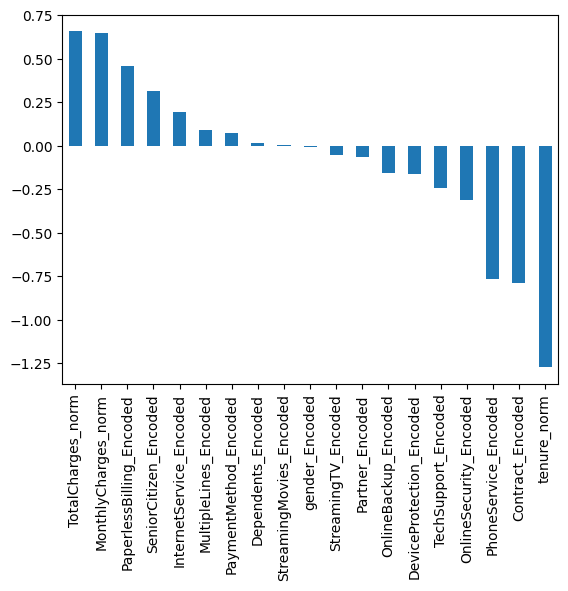

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  

lr = LogisticRegression()
result = lr.fit(X_train, y_train)

prediction_test = lr.predict(X_test)
print(accuracy_score(y_test, prediction_test))

weights = pd.Series(lr.coef_[0], index=X_upsample_temp.columns.values)
print (weights.sort_values(ascending = False).plot(kind='bar'))

In [12]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
conf = confusion_matrix(y_test, y_pred_dtc)
clf_report = classification_report(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Decision Tree is : 0.8531400966183574
Confusion Matrix : 
[[1205  331]
 [ 125 1444]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1536
           1       0.81      0.92      0.86      1569

    accuracy                           0.85      3105
   macro avg       0.86      0.85      0.85      3105
weighted avg       0.86      0.85      0.85      3105



0.7755233494363929


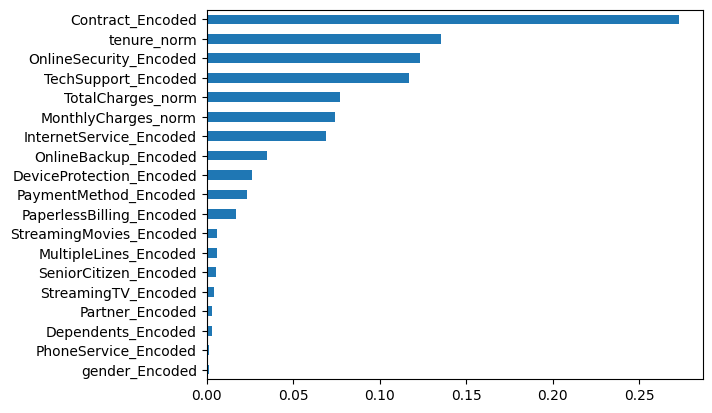

In [13]:
from sklearn.ensemble import RandomForestClassifier

rd_clf = RandomForestClassifier(
    n_estimators=1000 , 
    oob_score = True,
    n_jobs = -1,
    random_state = 0, 
    max_features = "auto",
    max_leaf_nodes = 30
)

rd_clf.fit(X_train, y_train)
prediction_test = rd_clf.predict(X_test)
print(accuracy_score(y_test, prediction_test))

importances = rd_clf.feature_importances_
weights = pd.Series(importances, index=X_upsample_temp.columns.values)
weights.sort_values().plot(kind = 'barh')
plt.show()

Accuracy Score of KNN is : 0.7578099838969404
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.67      0.73      1536
           1       0.72      0.84      0.78      1569

    accuracy                           0.76      3105
   macro avg       0.77      0.76      0.76      3105
weighted avg       0.77      0.76      0.76      3105



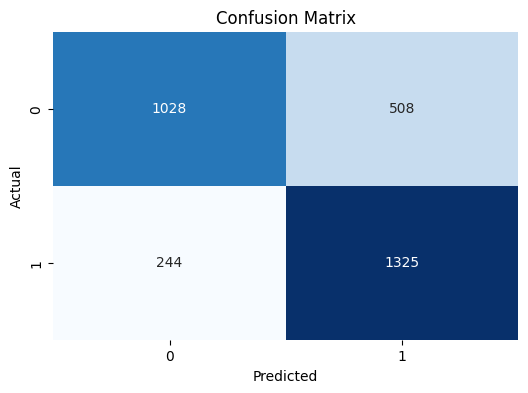

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
clf_report = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}")
print(f"Classification Report : \n{clf_report}")

# Convert the code below into function to display confusion matrix
confusion = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion, annot=True, fmt="d", cmap="Blues", cbar=False, 
    xticklabels=np.unique(y_train), yticklabels=np.unique(y_train)
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.svm import SVC

svm = SVC(kernel='linear') 
svm.fit(X_train,y_train)

preds = svm.predict(X_test)
print(accuracy_score(y_test, preds))
print(confusion_matrix(y_test,preds)) 

0.7623188405797101
[[1054  482]
 [ 256 1313]]


In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
conf = confusion_matrix(y_test, y_pred_gb)
clf_report = classification_report(y_test, y_pred_gb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_gb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.7745571658615137
Confusion Matrix : 
[[1112  424]
 [ 276 1293]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1536
           1       0.75      0.82      0.79      1569

    accuracy                           0.77      3105
   macro avg       0.78      0.77      0.77      3105
weighted avg       0.78      0.77      0.77      3105



In [17]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(X_train,y_train)

preds = ada.predict(X_test)
print(accuracy_score(y_test, preds))

0.7697262479871175


In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)
print(accuracy_score(y_test, preds))

0.8470209339774557


Accuracy: 0.81965
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1536
           1       0.79      0.87      0.83      1569

    accuracy                           0.82      3105
   macro avg       0.82      0.82      0.82      3105
weighted avg       0.82      0.82      0.82      3105



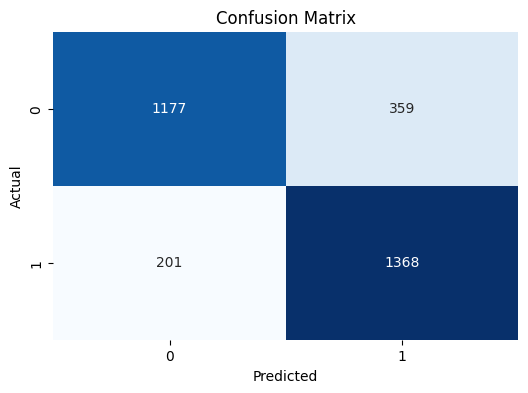

In [19]:
from lightgbm import LGBMClassifier 
from sklearn.metrics import classification_report

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train, verbose=0)

preds = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.5f}")

# Classification Report
class_report = classification_report(y_test, preds)
print(class_report)

# Confusion Matrix
confusion = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion, annot=True, fmt="d", cmap="Blues", cbar=False, 
    xticklabels=np.unique(y_train), yticklabels=np.unique(y_train)
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
from catboost import CatBoostClassifier
from IPython.display import clear_output

cat = CatBoostClassifier(iterations=100, verbose=0)
cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.7980676328502415
Confusion Matrix : 
[[1148  388]
 [ 239 1330]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1536
           1       0.77      0.85      0.81      1569

    accuracy                           0.80      3105
   macro avg       0.80      0.80      0.80      3105
weighted avg       0.80      0.80      0.80      3105



In [21]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

y_pred_etc = etc.predict(X_test)

acc_etc = accuracy_score(y_test, y_pred_etc)
conf = confusion_matrix(y_test, y_pred_etc)
clf_report = classification_report(y_test, y_pred_etc)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_etc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8888888888888888
Confusion Matrix : 
[[1310  226]
 [ 119 1450]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1536
           1       0.87      0.92      0.89      1569

    accuracy                           0.89      3105
   macro avg       0.89      0.89      0.89      3105
weighted avg       0.89      0.89      0.89      3105



In [22]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    ('Gradient Boosting Classifier', gb), 
    ('Cat Boost Classifier', cat), 
    ('XGboost', xgb),  
    ('Decision Tree', dtc),
    ('Extra Tree', etc), 
    ('Light Gradient', lgbm), 
    ('Random Forest', rd_clf), 
    ('Ada Boost', ada), 
    ('Logistic', lr),
    ('Knn', knn)
]
vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train, y_train)

y_pred_vc = vc.predict(X_test)

acc_vtc = accuracy_score(y_test, y_pred_vc)
conf = confusion_matrix(y_test, y_pred_vc)
clf_report = classification_report(y_test, y_pred_vc)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_vtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8041867954911434
Confusion Matrix : 
[[1161  375]
 [ 233 1336]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1536
           1       0.78      0.85      0.81      1569

    accuracy                           0.80      3105
   macro avg       0.81      0.80      0.80      3105
weighted avg       0.81      0.80      0.80      3105

